# Notebook 3
Export of slices as tiff images from a custom selection of lipids for optimal registration

### Load important modules

In [1]:
# Standard modules
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from xtiff import to_tiff

# multithreading
from threadpoolctl import threadpool_limits

# Move to root directory for easier module import
os.chdir("../../")

# Import custom function
from modules.tools.spectra import compute_normalized_image_per_lipid
from modules.maldi_data import MaldiData

# set thread limit
threadpool_limits(16)

# Ignore PerformanceWarning from Pytables
import warnings
from tables import PerformanceWarning
warnings.filterwarnings("ignore", category=PerformanceWarning)


### Load the slice data and the corresponding annotations

In [2]:
df_annotation = pd.read_csv("data/annotations/lipid_annotation.csv")


### Keep only most prevalent lipids

In [3]:
# Merge columns 'name' 'structure' and 'cations'
df_annotation["full_name_lipid"] = df_annotation["name"] + df_annotation["structure"] + df_annotation["cation"]
df_annotation = df_annotation.drop(["name", "structure", "cation"], axis=1)

In [4]:
# Keep only lipids present in all slices and remove all others
l_most_prevalent_lipids = list(df_annotation["full_name_lipid"].value_counts()[:60].index)
df_annotation = df_annotation[df_annotation["full_name_lipid"].isin(l_most_prevalent_lipids)]
df_annotation


,slice,theoretical m/z,min,max,num_pixels,mz_estimated,full_name_lipid
3,1,496.339750,496.3363,496.3415,48454.0,496.3403,LPC16:0H1
5,1,502.329190,502.3264,502.3319,6777.0,502.3298,LPCO-18:4H1
6,1,504.344850,504.3422,504.3464,59990.0,504.3453,LPCO- 18:3H1
7,1,506.360500,506.3596,506.3654,60606.0,506.3612,LPCO-18:2H1
13,1,526.326825,526.3229,526.3259,210.0,526.3250,LPCO-18:3na
...,...,...,...,...,...,...,...
23892,64,868.663800,868.6627,868.6664,17097.0,868.6640,HexCert42:0K
23897,64,874.499300,874.4961,874.5009,28221.0,874.4990,PE44:12 OHNa
23905,64,883.639900,883.6361,883.6393,8109.0,883.6378,PG42:1Na
23907,64,892.663700,892.6614,892.6650,10936.0,892.6633,PI-Cerd42:1H


### Get the corresponding images

In [6]:
# Dictionnary containing the list of lipid image (among most prevalent ones) for each slice
dic_l_images = {}
data = MaldiData()

# Loop over slices
for slice_index in data.get_slice_list(indices="brain_2"):
    print(slice_index, " started.")

    # Get lipid annotation for the current slice
    df_currentSlice = df_annotation[df_annotation["slice"] == slice_index]

    # Compute lipid distribution for all annotated lipids
    l_images = []
    for lipid in l_most_prevalent_lipids:
        row_lipid = df_currentSlice[df_currentSlice["full_name_lipid"] == lipid]
        # Sum over lipids that have similar annotation
        im_lipid = np.nansum(
            [
            compute_normalized_image_per_lipid(
                row[1]["min"],
                row[1]["max"],
                data.get_array_spectra(slice_index),
                data.get_array_lookup_pixels(slice_index),
                data.get_image_shape(slice_index),
                data.get_array_lookup_mz(slice_index),
                data.get_array_cumulated_lookup_mz_image(slice_index),
                data.get_divider_lookup(slice_index),
                data.get_array_peaks_transformed_lipids(slice_index),
                data.get_array_corrective_factors(slice_index),
                apply_transform=False,
                percentile_normalization=99,
                RGB_channel_format=True,
            )
                for row in row_lipid.iterrows()
            ],
            axis=0,
        )
        l_images.append([im_lipid, lipid])
    dic_l_images[slice_index] = l_images


33  started.


/home/colas/lbae/lbae/modules/tools/spectra.py:189: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "compute_image_using_index_lookup" failed type inference due to: Unknown attribute 'flatten' of type float32

File "modules/tools/spectra.py", line 250:
def compute_image_using_index_lookup(
    <source elided>
        if idx_lipid_right != -1:
            array_corrective_factors_lipid[:] = array_corrective_factors[idx_lipid_right].flatten()
            ^

During: typing of get attribute at /home/colas/lbae/lbae/modules/tools/spectra.py (250)

File "modules/tools/spectra.py", line 250:
def compute_image_using_index_lookup(
    <source elided>
        if idx_lipid_right != -1:
            array_corrective_factors_lipid[:] = array_corrective_factors[idx_lipid_right].flatten()
            ^

  @jit
/home/colas/lbae/lbae/modules/tools/spectra.py:189: NumbaWarning: 
Compilation is falling back to object mode WITHOUT looplifting enabled beca

34  started.
35  started.
36  started.
37  started.
38  started.
39  started.
40  started.
41  started.
42  started.
43  started.
44  started.
45  started.
46  started.
47  started.
48  started.
49  started.
50  started.
51  started.
52  started.
53  started.
54  started.
55  started.
56  started.
57  started.
58  started.
59  started.
60  started.
61  started.
62  started.
63  started.
64  started.


### Display results and choose the lipids that represent the brain best

In [7]:
# Register total ion content + main lipids in a jpg file
l_slice_indexs = data.get_slice_list(indices="brain_2")

# Build a huge canvas with lipids as rows and slices as columns
fig, ll_ax = plt.subplots(
    len(l_most_prevalent_lipids[:100]),
    len(l_slice_indexs),
    figsize=(160, len(l_most_prevalent_lipids[:100]) * 4),
)

# Loop over slices and add the lipid images in each column
for i, index in enumerate(l_slice_indexs):

    # Compute TIC in first row
    ll_ax[0, i].imshow(
        np.sum(
            [
                image[0]
                for index_lipid, image in enumerate(dic_l_images[index])
                if len(image[0].shape) > 0
            ],
            axis=0,
        )
    )
    ll_ax[0, i].axis("off")
    ll_ax[0, i].set_title("slice: " + str(index) + ", TIC ")

    # Invidiual lipids for remaining rows
    for j, image in enumerate(dic_l_images[index][:99]):
        try:
            ll_ax[j + 1, i].imshow(image[0])
            ll_ax[j + 1, i].axis("off")
            ll_ax[j + 1, i].set_title(
                "slice: " + str(index) + ", lipid: " + image[1] + " (" + str(j) + ")"
            )
        except:
            pass

plt.tight_layout()
plt.savefig("notebooks/data_processing/data/images/all_slices.jpg", dpi=72)
# fig.subplots_adjust(hspace=0.1)
plt.close()


In [8]:
# Define the lipids index we want to keep for registration
# NB: this must be redone everytime!
ll_index_to_keep = [
    [

        52,
        39,
        30,
        44,
        47,
    ],  # Red, full brain
    [
        1,
        2,
        3,
        17,
        18,
        37,
        42,
        43,
        45,
        46,
    ],  # Green, specific structures
    list(dic_l_images.keys()),  # Blue, TIC
]


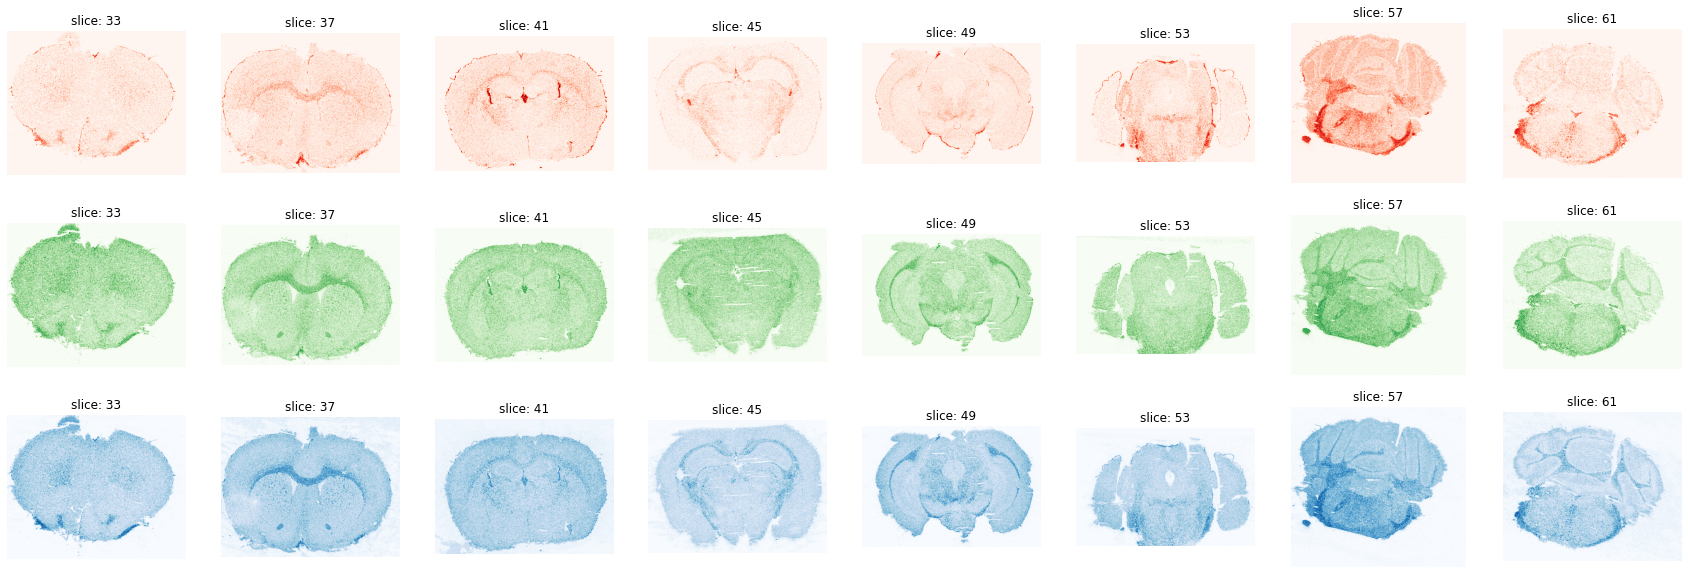

In [9]:
# Get an overview of the quality of the slices used for the registration with the current lipid selection
l_slice_indexs = data.get_slice_list(indices="brain_2")[::4]
l_cmap = ["Reds", "Greens", "Blues"]
fig, ll_ax = plt.subplots(3, len(l_slice_indexs), figsize=(30, 10))

# Loop over slices and compute image for each lipid selection
for i, index in enumerate(l_slice_indexs):
    for j, l_index_to_keep in enumerate(ll_index_to_keep):
        image = np.sum(
            [
                image[0]
                for index_lipid, image in enumerate(dic_l_images[index])
                if index_lipid in l_index_to_keep and len(image[0].shape) > 0
            ],
            axis=0,
        )
        image_norm = image / np.max(image) * 255
        ll_ax[j, i].imshow(image_norm, cmap=l_cmap[j])
        ll_ax[j, i].axis("off")
        ll_ax[j, i].set_title("slice: " + str(index))

plt.savefig("notebooks/data_processing/data/images/lipidschannels.png")
plt.show()


### Record the lipid selection as RGB image under tiff format for each slice

In [9]:
# Loop over slices
for slice_index in data.get_slice_list(indices="brain_2"):
    image_tiff = []
    # Loop over lipid selection
    for j, l_index_to_keep in enumerate(ll_index_to_keep):
        image = np.sum(
            [
                image[0]
                for index_lipid, image in enumerate(dic_l_images[slice_index])
                if index_lipid in l_index_to_keep and len(image[0].shape) > 0
            ],
            axis=0,
        )
        image_norm = image / np.max(image) * 255
        image_tiff.append(image_norm)

    # Export to tiff
    to_tiff(
        image_tiff,
        "notebooks/data_processing/data/images/tiff/slice_" + str(slice_index) + ".tiff",
        image_name="slice_" + str(slice_index),
        pixel_size=25,
    )



/home/colas/miniconda3/lib/python3.9/site-packages/xtiff/tiff.py:96: UserWarning: The specified OME-TIFF file name does not end with .ome.tiff: notebooks/data_processing/data/images/tiff/slice_34.tiff
  warnings.warn('The specified OME-TIFF file name does not end with .ome.tiff: {}'.format(file))
/home/colas/miniconda3/lib/python3.9/site-packages/xtiff/tiff.py:96: UserWarning: The specified OME-TIFF file name does not end with .ome.tiff: notebooks/data_processing/data/images/tiff/slice_35.tiff
  warnings.warn('The specified OME-TIFF file name does not end with .ome.tiff: {}'.format(file))
/home/colas/miniconda3/lib/python3.9/site-packages/xtiff/tiff.py:96: UserWarning: The specified OME-TIFF file name does not end with .ome.tiff: notebooks/data_processing/data/images/tiff/slice_36.tiff
  warnings.warn('The specified OME-TIFF file name does not end with .ome.tiff: {}'.format(file))
/home/colas/miniconda3/lib/python3.9/site-packages/xtiff/tiff.py:96: UserWarning: The specified OME-TIFF f